### One Owner Model

As a benchmark to the revenues generated from the producers inside the water regulation procedure, we will have a look at how a theoretical river system behaves, where every power plant is operated by one decision maker. The revenues are then distributed according to how much production capacity the individual producers have: If producer A has a total of 1 and producer B has a total of 2 for all equivalents, then B gets 2/3 of the revenue and A gets 1/3.  
We will see how much revenue will be generated and compare this to the revenue generated in the water regulation system.  

We can leave out the water regulation rules in these optimization models. We develop 

* Stochastic Bidding Model
* Stochastic Short-Term Optimization Model

We obviously don't have to do any balancing other than necessary in this problem, as we can freely adjust how much water we use without any constraint on average discharge. 


In [97]:
using JuMP
using CPLEX
using Distributions
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using SDDP
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end

includet(pwd() * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

In [98]:
filepath_Ljungan = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = pwd() *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = pwd() * "\\Results\\LambdaZero\\"
R, K, J = read_data(filepath_Ljungan)
print() 

j = J[1]
O, K_O = OtherParticipant(J, j , R)
pj = j.participationrate
pO = O.participationrate


println("Participation rate $(j.name): \n ", pj)
println("Participation rate $(O.name): \n ", pO)
println([k.spillreference for k in K_O])

Participation rate Sydkraft: 
 ________________________________
Flasjon  | 1.84    
Holsmjon | 0.0     

Participation rate Other: 
 ________________________________
Flasjon  | 2.68    
Holsmjon | 2.68    



[1.4, 1.4, 1.45, 2.4, 2.65, 2.5, 1.6, 1.45]


### Bidding Model

We approximate the bidding problem by using linear interpolation of volumes and presetting price Points, for example based on probabilities. From that we obtain the delivery obligation.

$$
y_t = \frac{c_t - P_{t,i} }{P_{t,i+1} - P_{t,i}} \cdot x_{i,t} + \frac{P_{t,i+1} - c_t }{P_{t,i+1} - P{t,i}} \cdot x_{i+1,t}, \qquad \text{if} \qquad P_{t,i} \leq c_t \leq P_{t,i+1}
$$

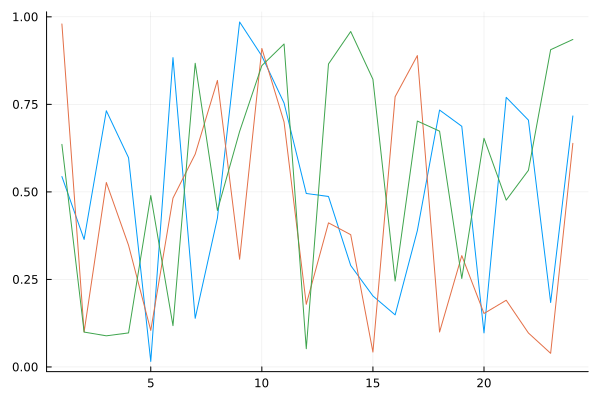

In [99]:
I = 5
T = 24
Stages = 7

mu_up = 1.0
mu_down = 0.3
S = 0.2

PPoints = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
@assert length(PPoints) == I + 1
Omega = [(inflow = Dict(r => 0.4 for r in R), price = rand(T)), (inflow = Dict(r => 0.6 for r in R), price = rand(T)), (inflow = Dict(r => 0.8 for r in R), price = rand(T))]
P = [1/length(Omega) for om in Omega]

Plots.plot(x = 1:T, [om.price for om in Omega], legend = false, show=true)

In [100]:
function subproblem_builder_single_bidding(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, ustart[k = K], Bin, SDDP.State, initial_value = 0)
    @variable(subproblem, 0 <= x[i = 1:I+1, t = 1:T] <= sum(k.equivalent * k.spillreference for k in K), SDDP.State, initial_value = 0)
    # Control Variables
    @variable(subproblem, y[t = 1:T] >= 0)
    @variable(subproblem, 0 <= Qreal[t = 1:T, r = R])
    @variable(subproblem, 0 <= Qeff[t = 1:T, k = K] <= k.spillreference)
    @variable(subproblem, 0 <= w[t = 1:T, k = K] <= k.equivalent * k.spillreference)
    @variable(subproblem, u[t = 1:T, k = K], Bin)
    @variable(subproblem, d[t = 1:T, k = K], Bin)
    @variable(subproblem, s[r = R] >= 0)
    @variable(subproblem, z_up[t = 1:T] >= 0)
    @variable(subproblem, z_down[t = 1:T] >= 0)
    # Random Variables
    @variable(subproblem, f[r = R])

    # Transition Function
    @constraint(subproblem, increasing[i = 1:I, t=1:T], x[i,t].out <= x[i+1,t].out)
    @constraint(subproblem, balance[r = R], l[r].out == l[r].in - sum(Qreal[t,r] for t in 1:T) + T * f[r] - s[r])
    @constraint(subproblem, planttrans1[k = K], ustart[k].in == u[1,k])
    @constraint(subproblem, planttrans2[k = K], ustart[k].out == u[T,k])

    # Constraints
    @constraint(subproblem, clearing[t=1:T], y[t] == sum(1* x[i,t].in +  1* x[i+1,t].in for i in 1:I-1))
    @constraint(subproblem, startup[t = 1:T-1, k = K], d[t,k] >= u[t+1,k] - u[t,k])
    @constraint(subproblem, activeplant[t = 1:T, k = K], w[t,k] <= u[t,k] * k.equivalent * k.spillreference)
    @constraint(subproblem, production[t = 1:T, k = K], w[t,k] <= sum(Qreal[t, r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
    @constraint(subproblem, obligation[t = 1:T], y[t] == sum(w[t, k] for k in K) + z_up[t] - z_down[t])
    # Parameterize Uncertainty and Objective Function
    SDDP.parameterize(subproblem, Omega, P) do om
        for r in R
            JuMP.fix(f[r], om.inflow[r], force=true)
        end
        # Define Set of active variables for each hour
        I_t = Dict(t => 0 for t in 1:T)
        for t in 1:T
            for i in 1:I
                if (om.price[t] >= PPoints[i]) && (om.price[t] <= PPoints[i+1])
                    I_t[t] = i
                end
            end
        end
        # Parameterize objective through uncertain price
        @stageobjective(subproblem, sum(om.price[t] * y[t] -  mu_up * z_up[t] + mu_down * z_down[t]  - sum(S * d[t,k] for k in K) for t in 1:T))
        # Fix / Deactivate constraints by setting their coefficients to appropriate values or all zero.
        for t in 1:T
            for i in 1:I
                if (i == I_t[t])
                    set_normalized_coefficient(clearing[t], x[i,t].in, -((om.price[t] - PPoints[i])/(PPoints[i+1] - PPoints[i])))
                    set_normalized_coefficient(clearing[t], x[i+1,t].in, -((PPoints[i+1] - om.price[t])/(PPoints[i+1] - PPoints[i])))
                else
                    set_normalized_coefficient(clearing[t], x[i,t].in, 0)
                    set_normalized_coefficient(clearing[t], x[i+1,t].in, 0)
                end
            end
        end
    end
end

subproblem_builder_single_bidding (generic function with 1 method)

In [101]:
model_single_bidding = SDDP.LinearPolicyGraph(
    subproblem_builder_single_bidding;
    stages = Stages,
    sense = :Max,
    upper_bound = Stages * sum(sum(k.spillreference * k.equivalent for k in K) for t in 1:T),
    optimizer = CPLEX.Optimizer
)

A policy graph with 7 nodes.
 Node indices: 1, 2, 3, 4, 5, 6, 7


In [102]:
SDDP.train(
    model_single_bidding;
    iteration_limit = 10,
    print_level = 0
)

### Short-Term Optimization

The problem is parameterized by a known demand $y$ in the first stage.
Bidding is removed from the optimization model. Determining a discharge schedule is the most important thing about the model.

24


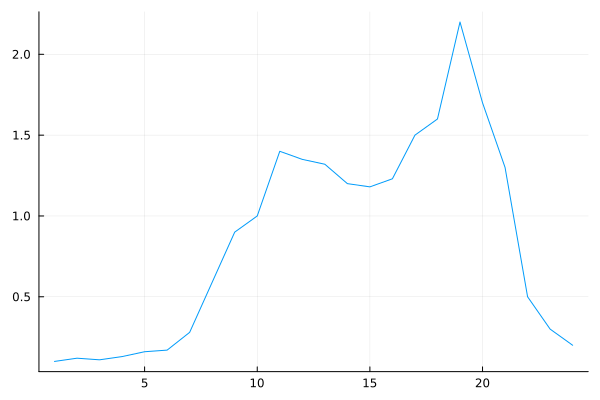

In [115]:
y_initial::Vector{Float64} = [0.1, 0.12, 0.11, 0.13, 0.16, 0.17, 0.28, 0.59, 0.9, 1.0, 1.4, 1.35, 1.32, 1.2, 1.18, 1.23, 1.5, 1.6, 2.2, 1.7, 1.3, 0.5, 0.3, 0.2]
println(length(y_initial))

Plots.plot(1:24, y, legend = false, show = true)

In [119]:
function subproblem_builder_single_short(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, ustart[k = K], Bin, SDDP.State, initial_value = 0)
    # Control Variables
    @variable(subproblem, y[t = 1:T])
    @variable(subproblem, Q[t = 1:T, r = R] >= 0)
    @variable(subproblem, 0 <= w[t = 1:T, k = K] <= k.spillreference * k.equivalent)
    @variable(subproblem, 0 <= u[t = 1:T, k = K], Bin)
    @variable(subproblem, 0 <= d[t = 1:T, k = K], Bin)
    if node == 1
        @variable(subproblem, z_up[t = 1:T] >= 0)
        @variable(subproblem, z_down[t = 1:T] >= 0)
    end
    @variable(subproblem, s[r = R] >= 0)
    # Random Variables
    @variable(subproblem, f[r = R])

    # Transition function
    @constraint(subproblem, balance[r = R], l[r].out == l[r].in - sum(Q[t, r] for t in 1:T) + T * f[r] - s[r])
    @constraint(subproblem, planttrans1[k = K], ustart[k].in == u[1,k])
    @constraint(subproblem, planttrans2[k = K], ustart[k].out == u[T,k])
    # Constraints
    if node == 1
        @constraint(subproblem, obligation[t = 1:T], y[t] == sum(w[t,k] for k in K) + z_up[t] - z_down[t])
    end
    @constraint(subproblem, startup[t = 1:T-1, k = K], d[t,k] >= u[t+1,k] - u[t,k])
    @constraint(subproblem, activeplant[t = 1:T, k = K], w[t,k] <= u[t,k] * k.equivalent * k.spillreference)
    @constraint(subproblem, production[t = 1:T, k = K], w[t,k] <= sum(Q[t, r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
    
    # Parameterize Uncertainty
    SDDP.parameterize(subproblem, Omega, P) do om
        if node == 1
            for t in 1:T
                JuMP.fix(y[t], y_initial[t])
            end
            @stageobjective(subproblem, sum(om.price[t] * y[t] - mu_up * z_up[t] + mu_down * z_down[t]  - sum(S * d[t,k] for k in K) for t in 1:T))
        else
            @stageobjective(subproblem, sum(om.price[t] * sum(w[t, k] for k in K) - sum(S * d[t, k] for k in K) for t in 1:T))
        end
    end
end

subproblem_builder_single_short (generic function with 1 method)

In [120]:
model_single_short = SDDP.LinearPolicyGraph(
    subproblem_builder_single_short;
    stages = Stages,
    sense = :Max,
    upper_bound = Stages * T * sum(k.spillreference * k.equivalent for k in K),
    optimizer = CPLEX.Optimizer
)

A policy graph with 7 nodes.
 Node indices: 1, 2, 3, 4, 5, 6, 7


In [121]:
SDDP.train(
    model_single_short;
    iteration_limit = 10
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 7
  state variables : 15
  scenarios       : 2.18700e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [1043, 1091]
  VariableRef in MOI.LessThan{Float64}    : [315, 315]
  VariableRef in MOI.ZeroOne              : [637, 637]
  AffExpr in MOI.LessThan{Float64}        : [624, 624]
  AffExpr in MOI.GreaterThan{Float64}     : [299, 299]
  AffExpr in MOI.EqualTo{Float64}         : [28, 52]
  VariableRef in MOI.GreaterThan{Float64} : [988, 1036]


numerical stability report
  matrix range     [7e-02, 2e+01]
  objective range  [2e-02, 1e+00]
  bounds range     [7e-02, 4e+04]
  rhs range        [0e+00, 0e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   5.502103e+02  5.376512e+02  3.830001e-01        28   1


         2   5.152223e+02  5.376512e+02  8.410001e-01        56   1


         3   5.685277e+02  5.376512e+02  1.278000e+00        84   1


         4   5.808570e+02  5.376512e+02  1.735000e+00       112   1


         5   5.502103e+02  5.376512e+02  2.325000e+00       140   1


         6   5.378810e+02  5.376512e+02  2.712000e+00       168   1


         7   5.701797e+02  5.376512e+02  3.106000e+00       196   1


         8   5.808570e+02  5.376512e+02  3.527000e+00       224   1


         9   5.232104e+02  5.376512e+02  3.905000e+00       252   1


        10   5.525516e+02  5.376512e+02  4.307000e+00       280   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 4.307000e+00
total solves   : 280
best bound     :  5.376512e+02
simulation ci  :  5.529707e+02 ± 1.408413e+01
numeric issues : 0
-------------------------------------------------------------------

